# Time Series航空公司服務量分析
多數資料集具備時間性，分析時間對結果的影響就是時間序列分析(Time Series)。

本篇資料採用航空公司之服務量，從1949年~1960年，11年之資料，每個月蒐集一次旅客數。分別使用**線性回歸**與Facebook所提供之**fbprophet**套件進行分析

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.linear_model import LinearRegression

### 1.載入csv檔
載入csv檔，該檔案須和ipynb檔放在同一資料夾

在執行此程式前，請先下載資料集，[下載點](https://github.com/Yi-Huei/bin/blob/master/datas/international-airline-passengers.csv)

In [3]:
df = pd.read_csv('./international-airline-passengers.csv', skipfooter=3)
df

<ipython-input-3-0f825f578fea>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('./international-airline-passengers.csv', skipfooter=3)


,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [4]:
X=pd.DataFrame(df[df.columns[0]].replace("-", "", regex=True).astype(int)) #為畫圖方便，除去-，並轉型為int
y=df[df.columns[1]] 

In [5]:
X.shape

(144, 1)

### 2. 線性回歸

In [6]:
lm = LinearRegression( )
lm.fit(X, y)

LinearRegression()

In [7]:
print('y={:.2f} x + {:.2f}'.format(lm.coef_[0], lm.intercept_))

y=0.32 x + -62153.98


### 3. 繪製真實數據與預測數據

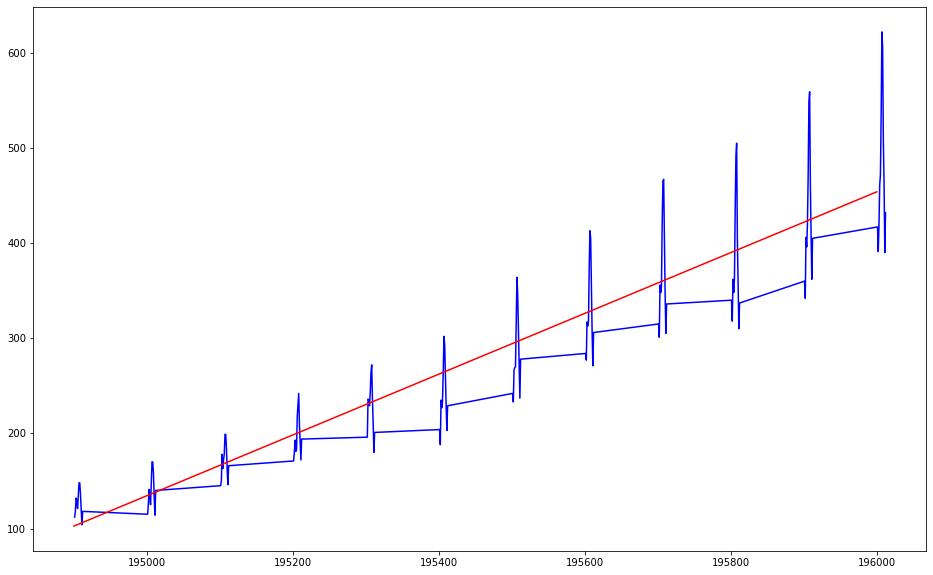

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure( figsize=(16, 10))

plt.plot(X.iloc[:,0], y, c='b')


x2=np.linspace(194900, 196000, 11)
y2=x2 * lm.coef_[0] + lm.intercept_
plt.plot(x2, y2, c='r')



藍色為原始數據，紅色為回歸線

由藍色線條可知，旅客數據有一定的循環，每年具有淡旺季之分，單純使用回歸無法處理此特性。

### 4. ACF與PACF
ACF : AutoCorrelation Function，自相關係數，
[參考網站](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)  
PACF: Partial AutoCorrelation Function，偏自相關係數，[參考網站](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html#statsmodels.tsa.stattools.pacf)

ACF與PACF解說[參考網站](https://setscholars.net/python-data-visualisation-for-business-analyst-how-to-do-autocorrelation-acf-and-partial-autocorrelation-pacf-plot-in-python/)

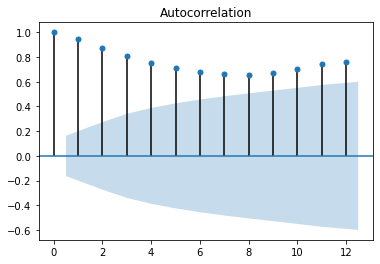

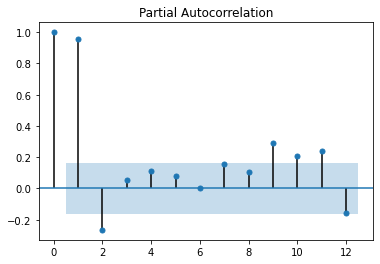

In [9]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
# 畫出 ACF 12 期的效應
sm.graphics.tsa.plot_acf(y, lags=12)
plt.show()
# 畫出 PACF 12 期的效應
sm.graphics.tsa.plot_pacf(y, lags=12)
plt.show()

### 5.Facebook fbprophet 套件
[參考網站連結](https://facebook.github.io/prophet/docs/quick_start.html)

使用本套件需先安裝以下套件: 
1. pip install plotly
2. conda install pystan -c conda-forge
3. conda install -c conda-forge fbprophet  
* 請注意Facebook套件會因為python版本不同，安裝方式不同，本篇採用python3.8.3版

#### 5.1 fbprophet 對數據要求
1. 本套件只接收2個欄位，一個時間、一個人次
2. 需定義時間欄位標題為ds，人次標題為y
3. 時間數據須為年-月-日

In [10]:
# 處理數據
df.columns = ['ds', 'y'] #將欄位標題改為ds(時間)，y(人次)
df['ds'] = df['ds'] + '-01' #原數據只有年月，要改成年月日
df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [11]:
# 查看數據資訊
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      144 non-null    object
 1   y       144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


#### 5.2 模型與訓練

In [12]:
from fbprophet import Prophet
fb = Prophet()
fb.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### 5.3 預測

In [13]:
# 延長預測到365期後
future = fb.make_future_dataframe(periods=365)
future

,ds
0,1949-01-01
1,1949-02-01
2,1949-03-01
3,1949-04-01
4,1949-05-01
...,...
504,1961-11-27
505,1961-11-28
506,1961-11-29
507,1961-11-30


In [14]:
# predict返回數據
forecast = fb.predict(future)
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          509 non-null    datetime64[ns]
 1   trend                       509 non-null    float64       
 2   yhat_lower                  509 non-null    float64       
 3   yhat_upper                  509 non-null    float64       
 4   trend_lower                 509 non-null    float64       
 5   trend_upper                 509 non-null    float64       
 6   additive_terms              509 non-null    float64       
 7   additive_terms_lower        509 non-null    float64       
 8   additive_terms_upper        509 non-null    float64       
 9   yearly                      509 non-null    float64       
 10  yearly_lower                509 non-null    float64       
 11  yearly_upper                509 non-null    float64       

ds : 時間  
yhat : y預測值  
yhat_lower : y預測值最低點  
yhat_upper : y預測值最高點

In [15]:
# 查看預測數據，最後5筆
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
504,1961-11-27,498.382393,468.578581,530.061719
505,1961-11-28,496.856777,466.666266,525.714710
506,1961-11-29,494.698423,464.268195,523.038041
507,1961-11-30,491.951751,464.239534,519.643305
508,1961-12-01,488.676395,458.841690,514.452118


#### 5.4 繪製圖形

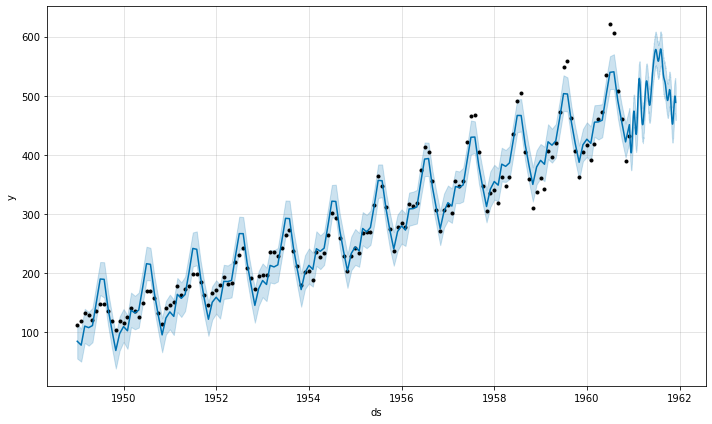

In [16]:
# 圖形1
fig1 = fb.plot(forecast)

黑色點為實際數據，藍色線為預測線，淺藍色區域是預測區間

可以發現此套件所作之預測很符合真實情況

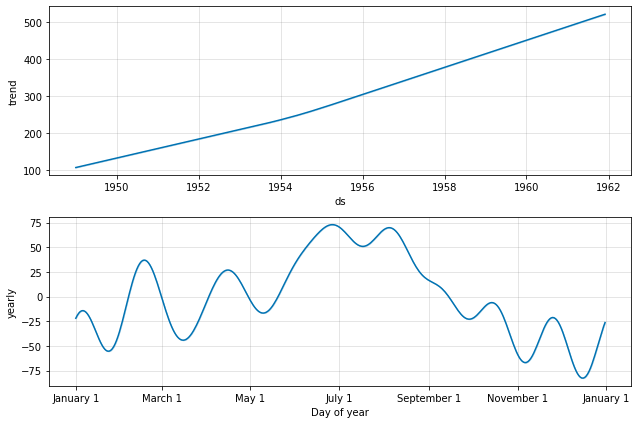

In [17]:
# 圖形2
fig2 = fb.plot_components(forecast)

第一章圖: 區域效應

第二張圖 : 月效應

由於本資料集數據最小單位為"月"，所以只能呈現到月效應。若收集的數據時間單位越小，如日，則可以顯示出星期效應...

#### 5.4 互動式統計圖
fbprophet也提供互動式圖表，然而網頁無法呈現互動是圖片，所以只顯示程式碼與圖片，而不執行。

In [18]:
# 互動式統計圖1
from fbprophet.plot import plot_plotly, plot_components_plotly
#plot_plotly(fb, forecast)

<img src="https://github.com/Yi-Huei/bin/blob/master/images/TimeSeries1.png?raw=true" style="zoom:70%" />

In [19]:
# 互動式統計圖2
#plot_components_plotly(fb, forecast)

<img src="https://github.com/Yi-Huei/bin/blob/master/images/TimeSeriers2.png?raw=true" style="zoom:70%" />